In [1077]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from scipy.stats import mannwhitneyu, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc as calculate_auc

In [1078]:
final_data1 = pd.read_csv('final_data1.csv')
gcs = pd.read_csv('sql/derived/gcs.csv')
crrt = pd.read_csv('sql/derived/crrt.csv')

gcs = gcs.sort_values('charttime').drop_duplicates(subset=['subject_id', 'stay_id'], keep='last')
crrt = crrt.sort_values('charttime').drop_duplicates(subset=['stay_id'], keep='last')

gcs_filtered = gcs[['subject_id', 'stay_id', 'gcs']]
crrt_filtered = crrt[['stay_id', 'crrt_mode']]

merged_gcs = pd.merge(final_data1, gcs_filtered, on=['subject_id', 'stay_id'], how='left')

merged_crrt = pd.merge(final_data1[['subject_id', 'stay_id']], crrt_filtered, on='stay_id', how='left')

final_merged = pd.merge(merged_gcs, merged_crrt, on=['subject_id', 'stay_id'], how='left')

final_merged = final_merged.drop_duplicates(subset=['subject_id', 'stay_id'], keep='last')

In [1079]:
print(final_merged.shape)

(1024, 20)


In [1080]:
chemistry = pd.read_csv('sql/derived/chemistry.csv')

In [1081]:
chemistry = chemistry.sort_values('charttime').drop_duplicates(subset=['subject_id'], keep='last')

chemistry_filtered = chemistry[['subject_id', 'bun', 'sodium']]
final_merged = pd.merge(final_merged, chemistry_filtered, on='subject_id', how='left')

In [1082]:
print(final_merged.shape)

(1024, 22)


In [1083]:
bg = pd.read_csv('sql/derived/bg.csv')
vitals = pd.read_csv('sql/derived/vitalsign.csv')

In [1084]:
bg = bg.sort_values('charttime').drop_duplicates(subset=['subject_id'], keep='last')
vitals = vitals.sort_values('charttime').drop_duplicates(subset=['subject_id'], keep='last')

bg_filtered = bg[['subject_id', 'hemoglobin', 'temperature']]
vitals_filtered = vitals[['subject_id', 'sbp', 'dbp', 'spo2']]

merged_bg = pd.merge(final_merged, bg_filtered, on='subject_id', how='left')

final_merged = pd.merge(merged_bg, vitals_filtered, on='subject_id', how='left')

In [1085]:
urine_output_rate = pd.read_csv('sql/derived/urine_output_rate.csv')
ventilation = pd.read_csv('sql/derived/ventilation.csv')

urine_output_rate = urine_output_rate.sort_values('charttime').drop_duplicates(subset=['stay_id'], keep='last')
ventilation = ventilation.sort_values('endtime').drop_duplicates(subset=['stay_id'], keep='last')

urine_filtered = urine_output_rate[['stay_id', 'uo']]
ventilation_filtered = ventilation[['stay_id', 'ventilation_status']]

merged_urine = pd.merge(final_merged, urine_filtered, on='stay_id', how='left')

final_merged = pd.merge(merged_urine, ventilation_filtered, on='stay_id', how='left')

In [1086]:
print(final_merged.shape)

(1024, 29)


In [1087]:
final_merged.head(5)

,subject_id,stay_id,los,chartdate,icd_code_x,icd_version,icd_code_y,long_title,gender,anchor_age,...,crrt_mode,bun,sodium,hemoglobin,temperature,sbp,dbp,spo2,uo,ventilation_status
0,17675016,36961856,16.921725,2173-04-03,9672,9,78552,Septic shock,M,73,...,NaN,11.0,141.0,NaN,NaN,NaN,NaN,NaN,50.0,InvasiveVent
1,19695954,30113662,2.534757,2197-11-08,3893,9,78552,Septic shock,F,73,...,NaN,58.0,139.0,NaN,NaN,147.0,38.0,98.0,120.0,SupplementalOxygen
2,11880923,30132571,17.632257,2126-01-15,3990,9,78552,Septic shock,M,66,...,CVVHDF,34.0,139.0,NaN,NaN,121.0,56.0,97.0,100.0,SupplementalOxygen
3,18343701,30139247,2.832755,2158-06-30,8872,9,78552,Septic shock,M,83,...,NaN,71.0,137.0,11.2,NaN,NaN,NaN,NaN,200.0,SupplementalOxygen
4,14514730,30218515,2.733021,2157-09-05,3734,9,78552,Septic shock,F,76,...,NaN,12.0,136.0,NaN,NaN,NaN,NaN,96.0,150.0,SupplementalOxygen


In [1088]:
kdigo_creatinine = pd.read_csv('sql/derived/kdigo_creatinine.csv')

kdigo_creatinine = kdigo_creatinine.sort_values('charttime').drop_duplicates(subset=['stay_id'], keep='last')

kdigo_filtered = kdigo_creatinine[['stay_id', 'creat', 'creat_low_past_48hr']]

final_merged = pd.merge(final_merged, kdigo_filtered, on='stay_id', how='left')

In [1089]:
print(final_merged.shape)

(1024, 31)


In [1090]:
print(final_merged.head())
print(final_merged.columns)

   subject_id   stay_id        los   chartdate  icd_code_x  icd_version  \
0    17675016  36961856  16.921725  2173-04-03        9672            9   
1    19695954  30113662   2.534757  2197-11-08        3893            9   
2    11880923  30132571  17.632257  2126-01-15        3990            9   
3    18343701  30139247   2.832755  2158-06-30        8872            9   
4    14514730  30218515   2.733021  2157-09-05        3734            9   

   icd_code_y    long_title gender  anchor_age  ...  sodium  hemoglobin  \
0       78552  Septic shock      M          73  ...   141.0         NaN   
1       78552  Septic shock      F          73  ...   139.0         NaN   
2       78552  Septic shock      M          66  ...   139.0         NaN   
3       78552  Septic shock      M          83  ...   137.0        11.2   
4       78552  Septic shock      F          76  ...   136.0         NaN   

   temperature    sbp   dbp  spo2     uo  ventilation_status  creat  \
0          NaN    NaN   NaN

In [1091]:
charlson = pd.read_csv('sql/derived/charlson.csv')

charlson = charlson.drop_duplicates(subset=['subject_id'], keep='last')

charlson_filtered = charlson[['subject_id', 'malignant_cancer', 'metastatic_solid_tumor']]
final_merged = pd.merge(final_merged, charlson_filtered, on='subject_id', how='left')


In [1092]:
print(final_merged.shape)

(1024, 33)


In [1093]:
admission = pd.read_csv('sql/hosp/admissions.csv')

admission = admission.drop_duplicates(subset=['subject_id'], keep='last')
admission_filtered = admission[['subject_id', 'hospital_expire_flag']]
final_merged = pd.merge(final_merged, admission_filtered, on='subject_id', how='left')

final_merged.to_csv('Final.csv', index=False)


In [1094]:
print(final_merged.shape)

(1024, 34)


In [1095]:
df = pd.read_csv('Final.csv')

In [1096]:
def describe_numerical(data):
    return data.median(), data.quantile(0.25), data.quantile(0.75)

def describe_categorical(data):
    freq = data.value_counts()
    percent = data.value_counts(normalize=True) * 100
    return pd.DataFrame({'Frequency': freq, 'Percentage': percent})

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns

print("Numerical Features Descriptive Statistics:")
for feature in numerical_features:
    median, q1, q3 = describe_numerical(df[feature])
    print(f"{feature}: Median = {median}, IQR = {q1}-{q3}")

print("\nCategorical Features Descriptive Statistics:")
for feature in categorical_features:
    desc = describe_categorical(df[feature])
    print(f"{feature}:\n{desc}\n")


Numerical Features Descriptive Statistics:
subject_id: Median = 14852710.0, IQR = 12499857.75-17280290.75
stay_id: Median = 33760809.5, IQR = 31778043.25-36473468.0
los: Median = 5.151406250000001, IQR = 3.047010995370371-10.418648726851853
icd_code_x: Median = 4182.0, IQR = 3729.75-8848.0
icd_version: Median = 9.0, IQR = 9.0-9.0
icd_code_y: Median = 78552.0, IQR = 78552.0-78552.0
anchor_age: Median = 76.0, IQR = 71.0-82.0
admission_number: Median = 1.0, IQR = 1.0-1.0
hadm_id: Median = 25131982.0, IQR = 22557433.25-27494169.75
scr_min: Median = 1.1, IQR = 0.8-1.7
scr_baseline: Median = 1.0, IQR = 0.6345387553721196-1.5
ckd: Median = 0.0, IQR = 0.0-1.0
mdrd_est: Median = 0.1481589316413787, IQR = 0.1439330656082084-0.6272377563637778
HR: Median = 87.0, IQR = 75.0-101.25
Respi_rate: Median = 87.0, IQR = 75.0-101.25
gcs: Median = 15.0, IQR = 14.0-15.0
bun: Median = 40.0, IQR = 25.0-65.0
sodium: Median = 139.0, IQR = 135.0-142.0
hemoglobin: Median = 9.5, IQR = 8.674999999999999-10.95
tempe

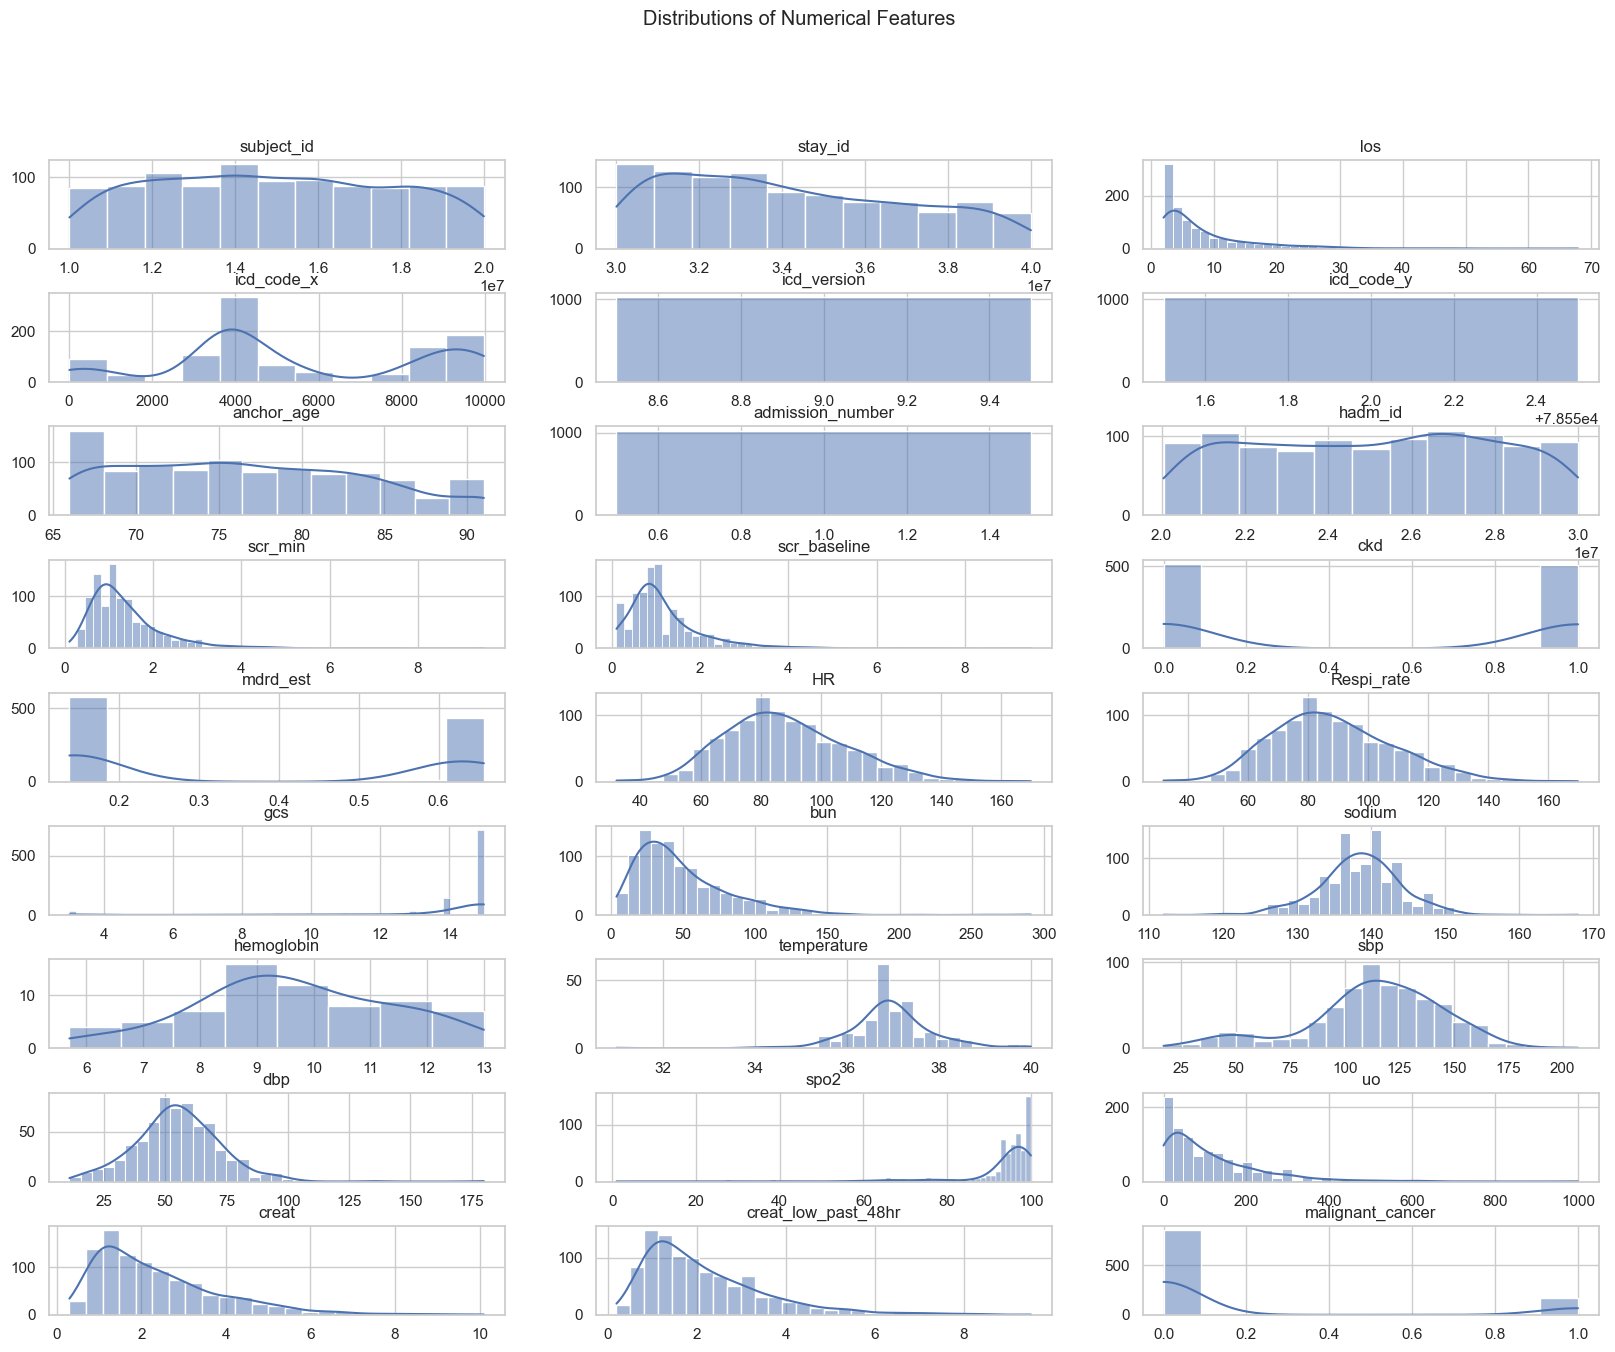

In [1097]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
fig, axes = plt.subplots(nrows=len(numerical_features)//3, ncols=3, figsize=(20, 15))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Numerical Features')

for ax, feat in zip(axes.flatten(), numerical_features):
    sns.histplot(df[feat], kde=True, ax=ax)
    ax.set_title(feat)
    ax.set_xlabel('')
    ax.set_ylabel('')

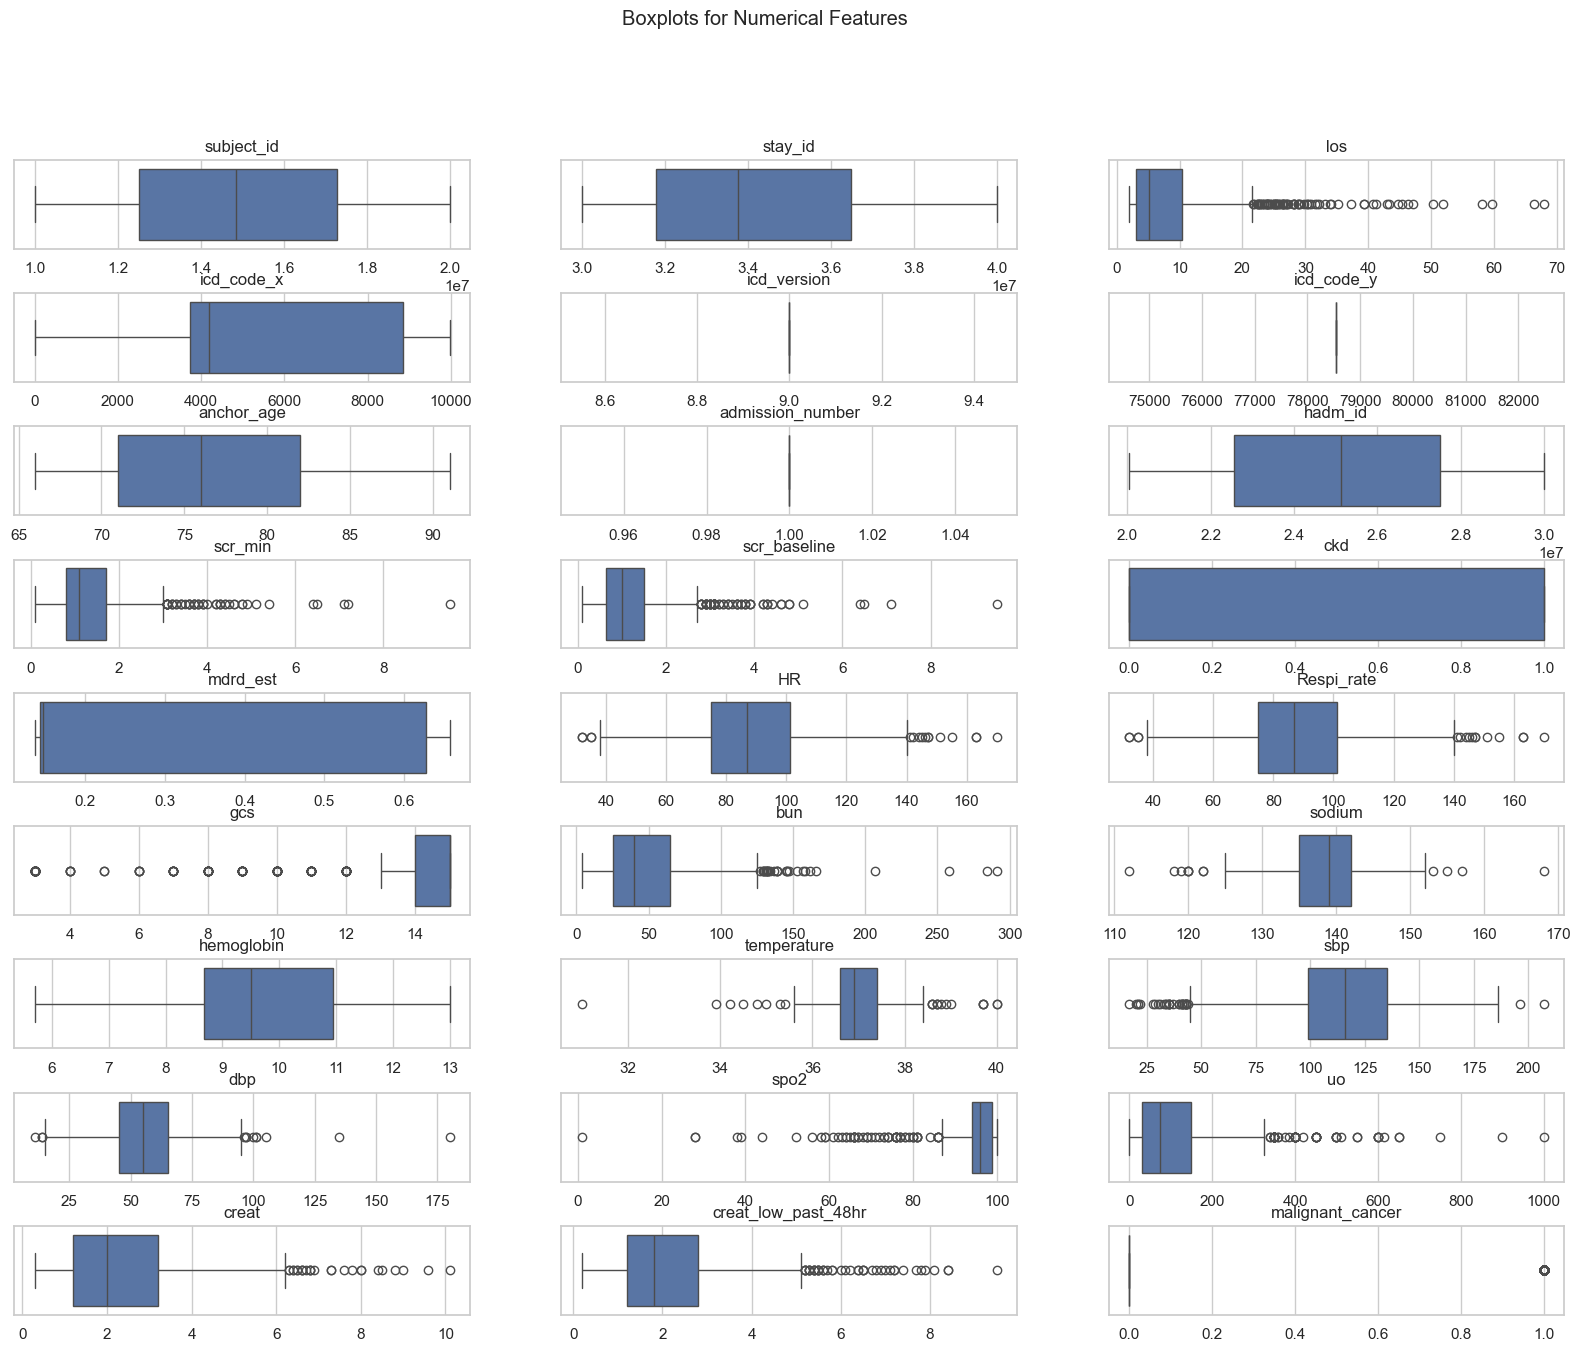

In [1098]:
fig, axes = plt.subplots(nrows=len(numerical_features)//3, ncols=3, figsize=(20, 15))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Boxplots for Numerical Features')

for ax, feat in zip(axes.flatten(), numerical_features):
    sns.boxplot(x=df[feat], ax=ax)
    ax.set_title(feat)
    ax.set_xlabel('')
    ax.set_ylabel('')

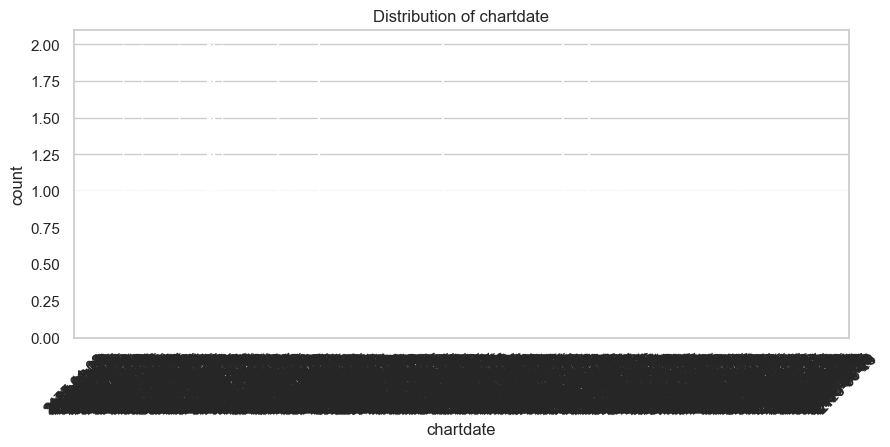

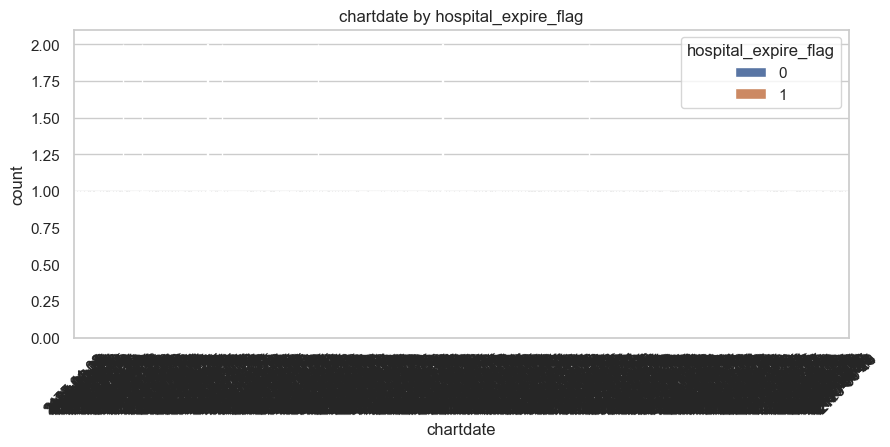

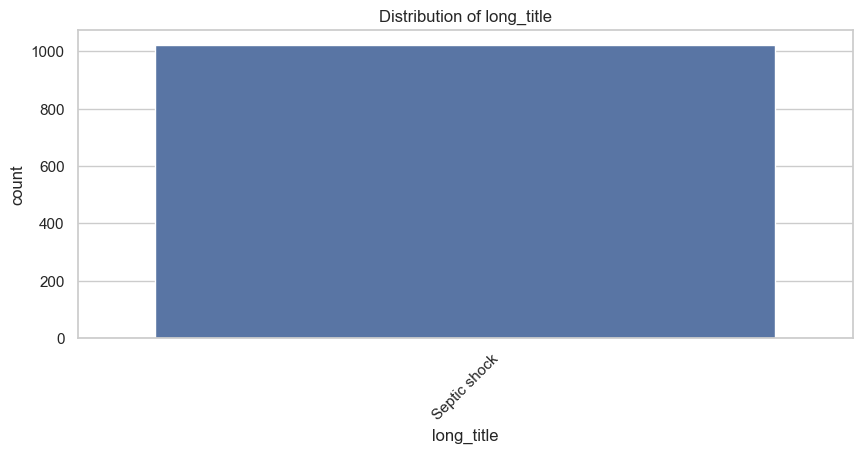

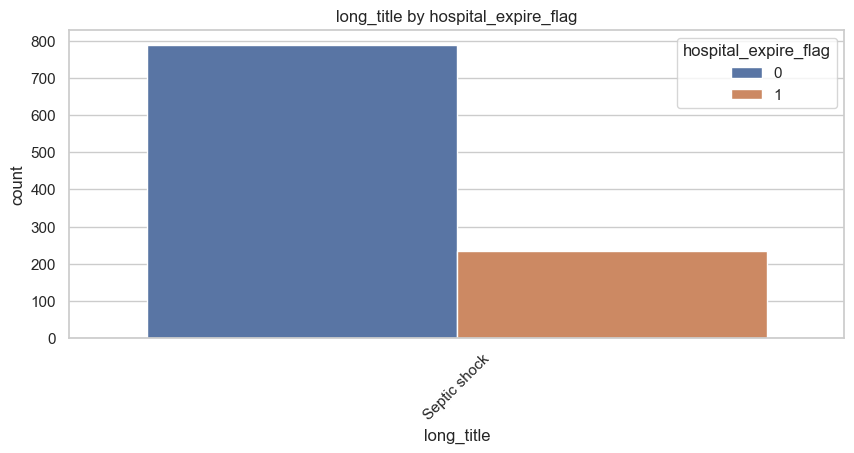

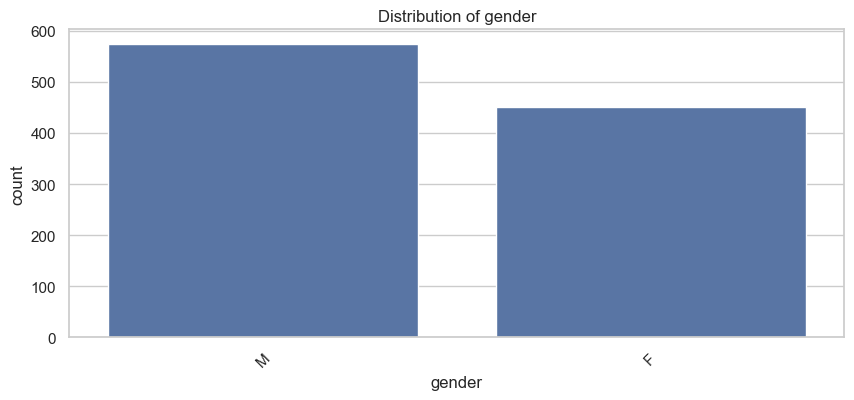

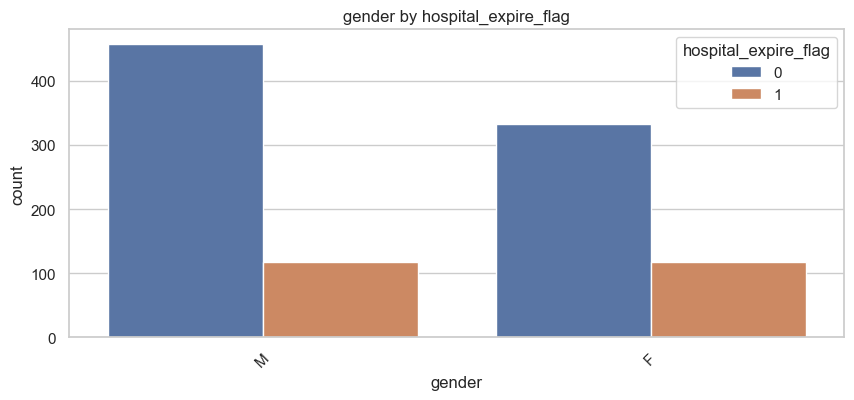

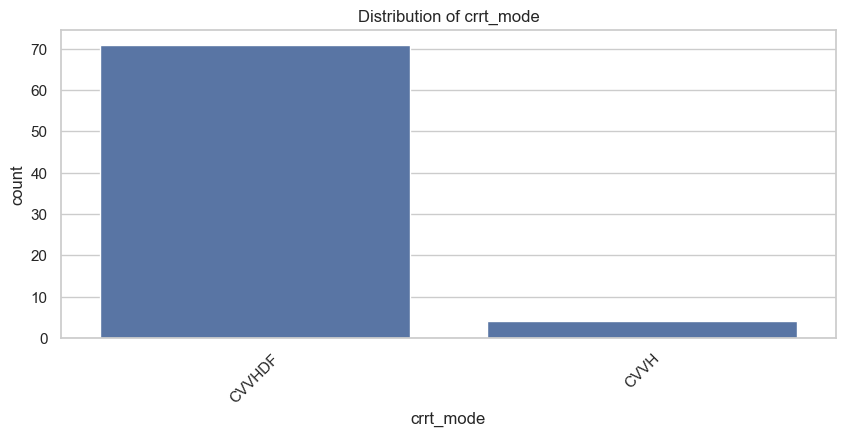

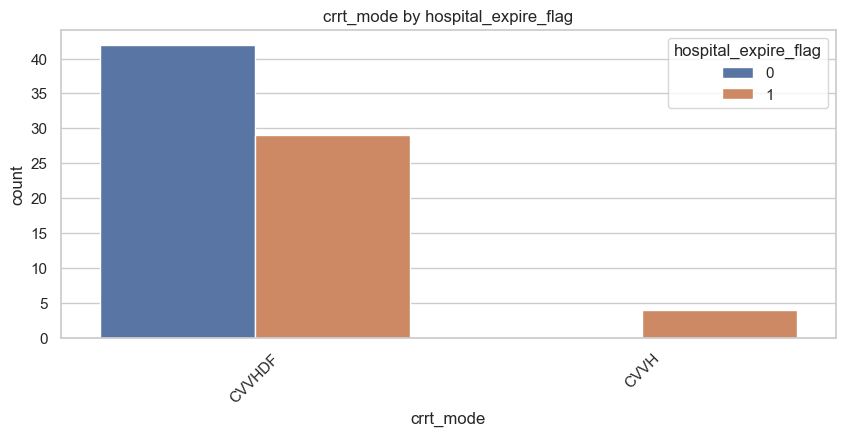

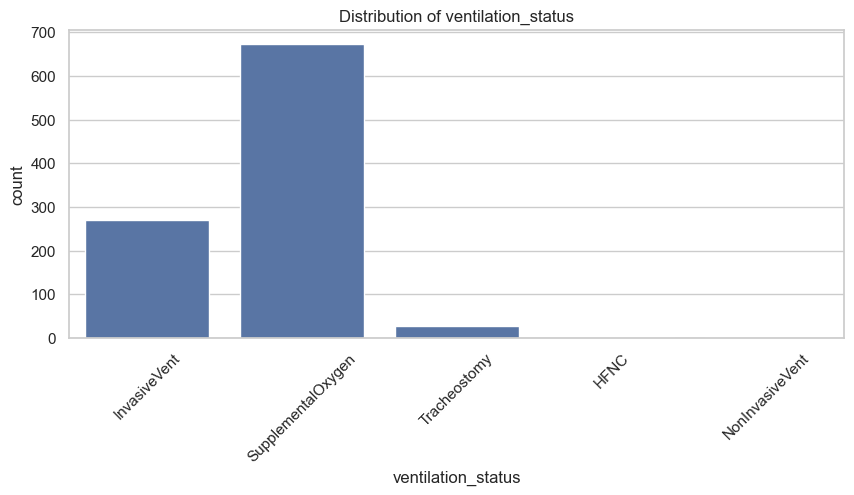

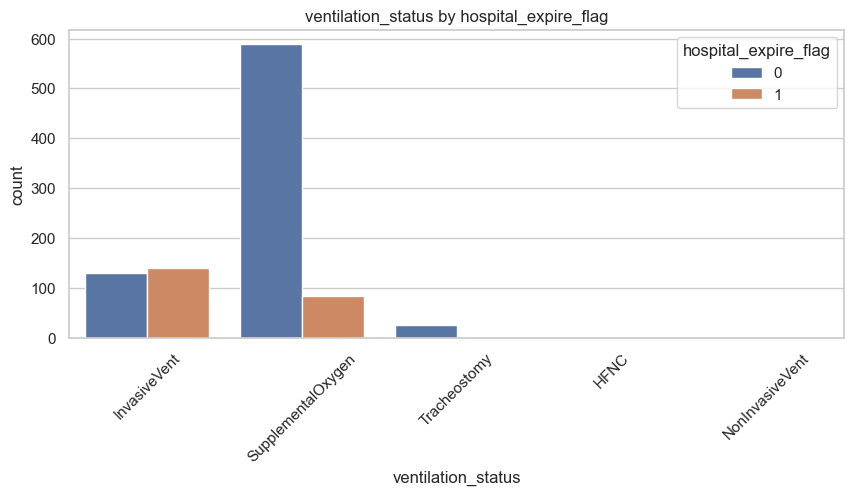

In [1099]:
categorical_features = df.select_dtypes(include=['object']).columns

for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=feature, data=df)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

    if 'hospital_expire_flag' in df.columns: 
        plt.figure(figsize=(10, 4))
        sns.countplot(x=feature, hue='hospital_expire_flag', data=df)
        plt.title(f'{feature} by hospital_expire_flag')
        plt.xticks(rotation=45)
        plt.show()

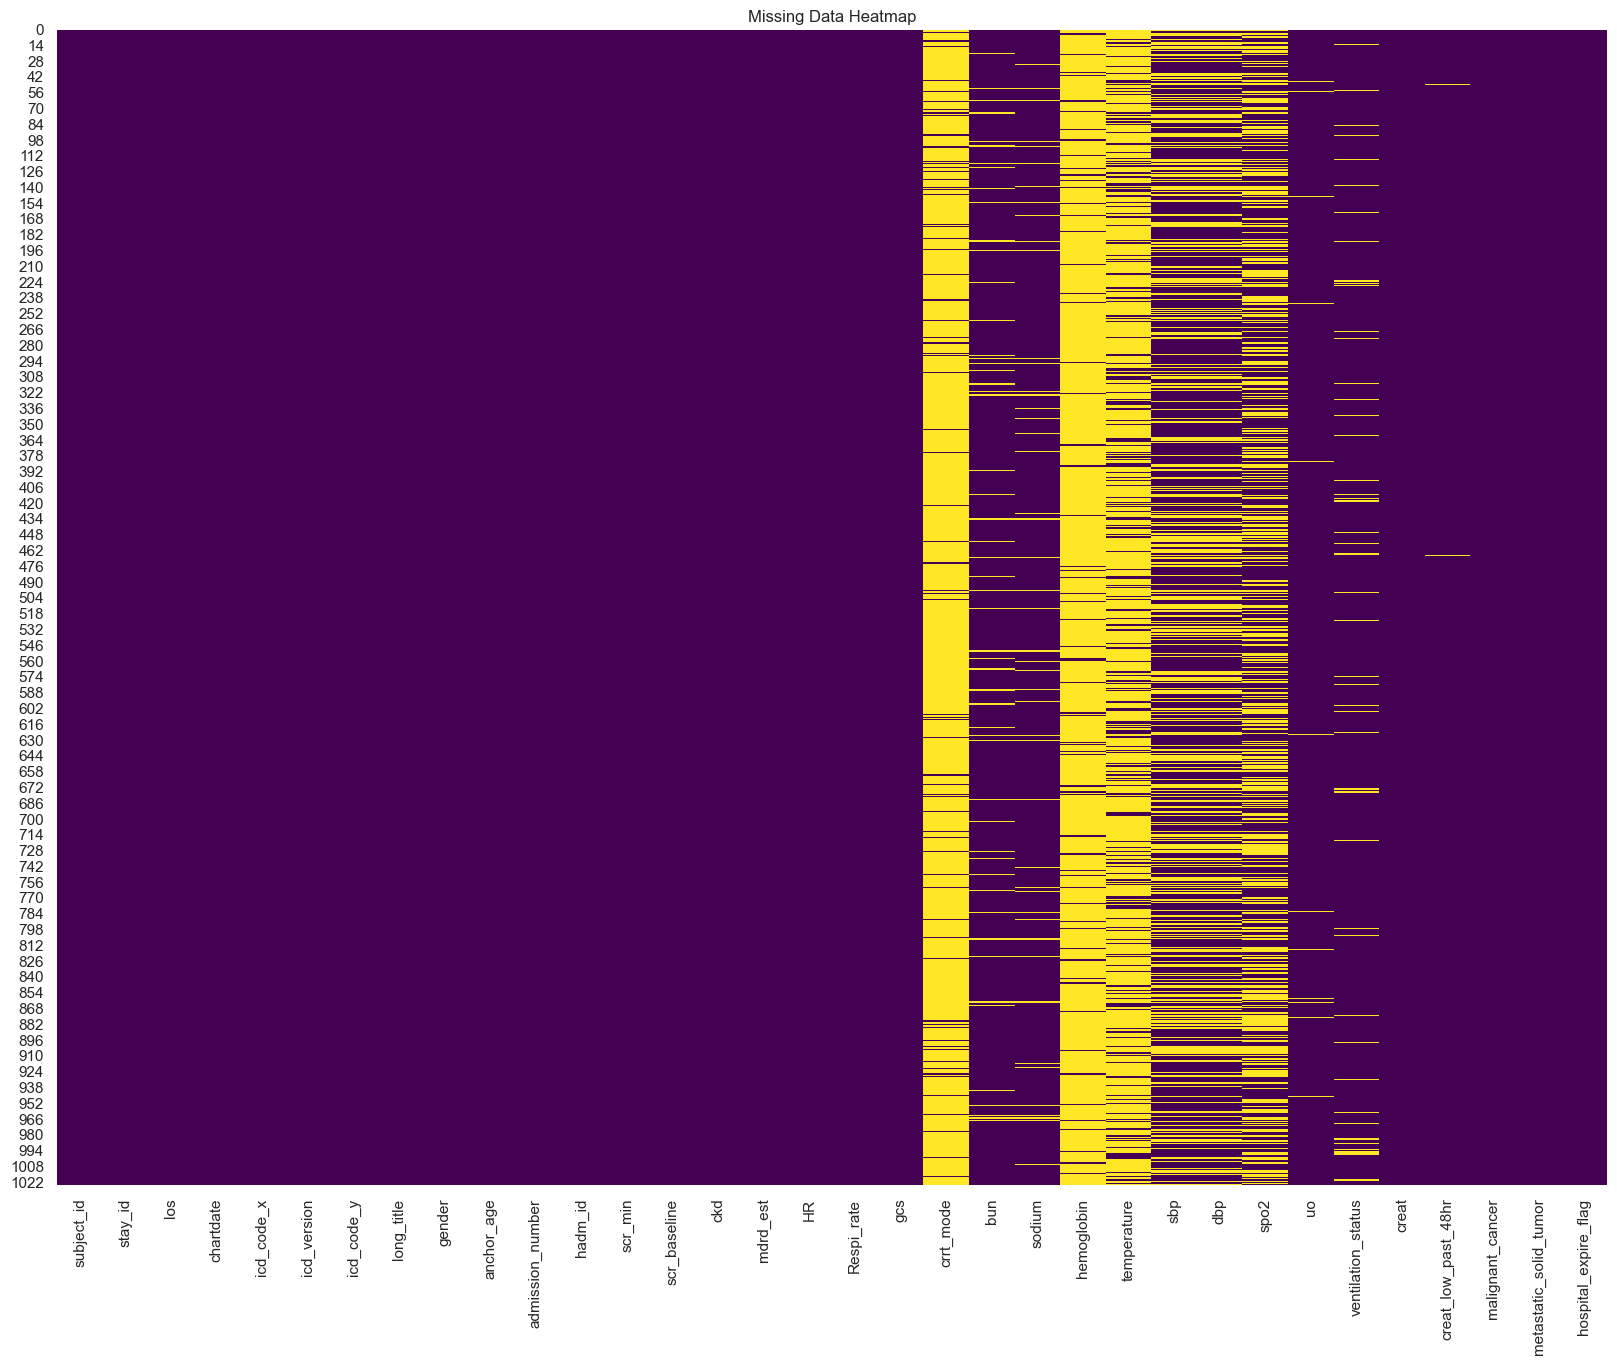

In [1100]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [1101]:
df = pd.get_dummies(df, drop_first=True)  

In [1102]:
for column in df.select_dtypes(include=['int', 'float']).columns:
    median_value = df[column].median()  
    df[column] = df[column].fillna(median_value)  

for column in df.select_dtypes(include=['object']).columns:
    mode_value = df[column].mode()[0] 
    df[column] = df[column].fillna(mode_value) 

In [1103]:
for column in df.select_dtypes(include=['int', 'float']).columns:
    lower_bound = df[column].quantile(0.01)
    upper_bound = df[column].quantile(0.99)
    df[column] = np.clip(df[column], lower_bound, upper_bound)


In [1104]:
variance_filter = VarianceThreshold(threshold=0.01)
df = pd.DataFrame(variance_filter.fit_transform(df), columns=df.columns[variance_filter.get_support()])

In [1105]:
df

,subject_id,stay_id,los,icd_code_x,anchor_age,hadm_id,scr_min,scr_baseline,ckd,mdrd_est,...,creat,creat_low_past_48hr,malignant_cancer,metastatic_solid_tumor,hospital_expire_flag,gender_M,crrt_mode_CVVHDF,ventilation_status_InvasiveVent,ventilation_status_SupplementalOxygen,ventilation_status_Tracheostomy
0,17675016.0,36961856.00,16.921725,9672.0,73.0,29235706.0,0.8,0.8,0.0,0.146122,...,1.1,1.1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,19695954.0,30113662.00,2.534757,3893.0,73.0,26918319.0,1.3,1.3,1.0,0.629041,...,1.4,1.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,11880923.0,30132571.00,17.632257,3990.0,66.0,21662658.0,1.2,1.2,1.0,0.147872,...,2.2,1.6,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,18343701.0,30139247.00,2.832755,8872.0,83.0,26846317.0,1.8,1.8,1.0,0.142315,...,1.9,2.3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,14514730.0,30218515.00,2.733021,3734.0,76.0,27259293.0,0.9,0.9,0.0,0.626945,...,0.9,0.9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,13698034.0,39480033.00,2.899479,9925.0,67.0,20572259.0,0.9,0.9,0.0,0.148302,...,1.2,0.9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1020,18182810.0,39512099.00,2.107604,7768.0,66.0,27617178.0,0.9,0.9,0.0,0.622237,...,1.1,1.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1021,15696810.0,39536798.00,6.846759,4610.0,70.0,26898352.0,1.0,1.0,0.0,0.615489,...,1.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1022,10689288.0,39717538.00,6.049352,8856.0,88.0,26810801.0,1.1,1.1,1.0,0.643919,...,1.1,1.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1106]:
X = df.drop('hospital_expire_flag', axis=1)
y = df['hospital_expire_flag']

In [1107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# SVM
svm = SVC(probability=True)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
y_pred_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]

# Calculating the accuracy and AUC
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression AUC:", auc_lr)
print("SVM Accuracy:", accuracy_svm)
print("SVM AUC:", auc_svm)

Logistic Regression Accuracy: 0.7804878048780488
Logistic Regression AUC: 0.805548074333423
SVM Accuracy: 0.8097560975609757
SVM AUC: 0.8656073256127121


In [1108]:
X = pd.get_dummies(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Add constant for statsmodels
X_scaled = add_constant(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = Logit(y_train, X_train).fit()

print(model.summary())


Optimization terminated successfully.
         Current function value: 0.396125
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     hospital_expire_flag   No. Observations:                  819
Model:                            Logit   Df Residuals:                      789
Method:                             MLE   Df Model:                           29
Date:                  Sat, 30 Nov 2024   Pseudo R-squ.:                  0.2627
Time:                          05:22:31   Log-Likelihood:                -324.43
converged:                         True   LL-Null:                       -440.01
Covariance Type:              nonrobust   LLR p-value:                 2.206e-33
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                 

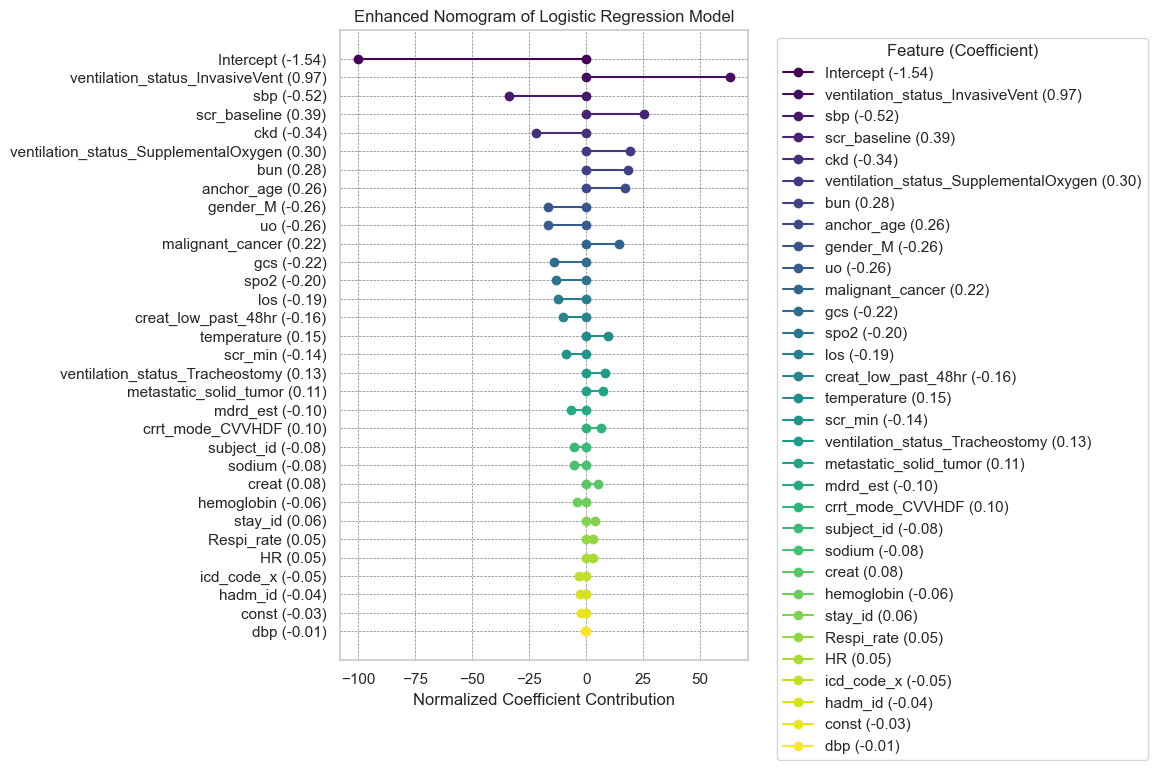

In [1109]:
model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = np.hstack([model.intercept_, model.coef_[0]])
features = ['Intercept'] + list(X_train.columns)


coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

max_coef = coef_df['Coefficient'].abs().max()
coef_df['Norm_Coefficient'] = coef_df['Coefficient'] / max_coef * 100 

coef_df = coef_df.sort_values(by='Norm_Coefficient', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(coef_df)))  

for idx, (feature, coeff, norm_coeff) in enumerate(zip(coef_df['Feature'], coef_df['Coefficient'], coef_df['Norm_Coefficient'])):
    ax.plot([0, norm_coeff], [idx, idx], marker='o', label=f"{feature} ({coeff:.2f})", color=colors[idx])

ax.set_yticks(range(len(coef_df)))
ax.set_yticklabels([f"{row['Feature']} ({row['Coefficient']:.2f})" for _, row in coef_df.iterrows()])
ax.set_xlabel("Normalized Coefficient Contribution")
ax.set_title("Enhanced Nomogram of Logistic Regression Model")
ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
ax.legend(title="Feature (Coefficient)", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.invert_yaxis()

plt.tight_layout()
plt.show()

KNN - Accuracy: 0.8049, AUC: 0.7724
Decision Tree - Accuracy: 0.7610, AUC: 0.6324
Random Forest - Accuracy: 0.8439, AUC: 0.8767


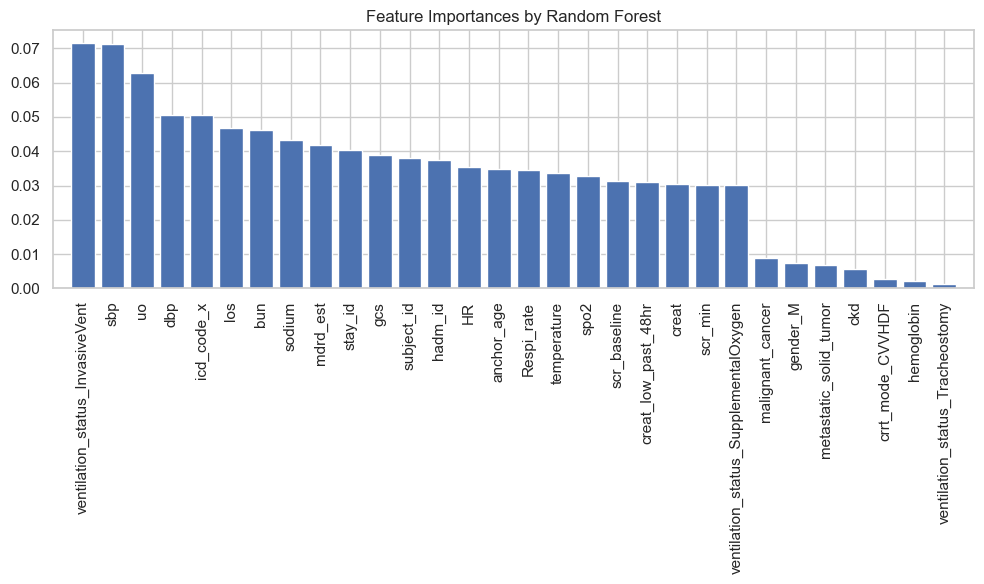

In [1110]:
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = (accuracy, auc)

    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

# Feature importance for tree-based models
if 'Random Forest' in models:
    importances = models['Random Forest'].feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances by Random Forest')
    plt.bar(range(X_train.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_train.shape[1]), [X.columns[i] for i in indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()
    plt.show()


In [1111]:
df = pd.read_csv('Final.csv')

In [1112]:
df.columns

Index(['subject_id', 'stay_id', 'los', 'chartdate', 'icd_code_x',
       'icd_version', 'icd_code_y', 'long_title', 'gender', 'anchor_age',
       'admission_number', 'hadm_id', 'scr_min', 'scr_baseline', 'ckd',
       'mdrd_est', 'HR', 'Respi_rate', 'gcs', 'crrt_mode', 'bun', 'sodium',
       'hemoglobin', 'temperature', 'sbp', 'dbp', 'spo2', 'uo',
       'ventilation_status', 'creat', 'creat_low_past_48hr',
       'malignant_cancer', 'metastatic_solid_tumor', 'hospital_expire_flag'],
      dtype='object')

In [1113]:
X = df[['bun', 'crrt_mode', 'gcs', 'HR', 'Respi_rate','malignant_cancer', 'anchor_age','creat_low_past_48hr', 'ventilation_status', 'ckd' ]]
y = df['hospital_expire_flag']  

categorical_cols = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(exclude=['object']).columns),
        ('cat', categorical_transformer, categorical_cols)
    ])

clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',  RandomForestClassifier(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['bun', 'gcs', 'HR', 'Respi_rate', 'malignant_cancer', 'anchor_age',
       'creat_low_past_48hr', 'ckd'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['crrt_mode', 'ventilation_status'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

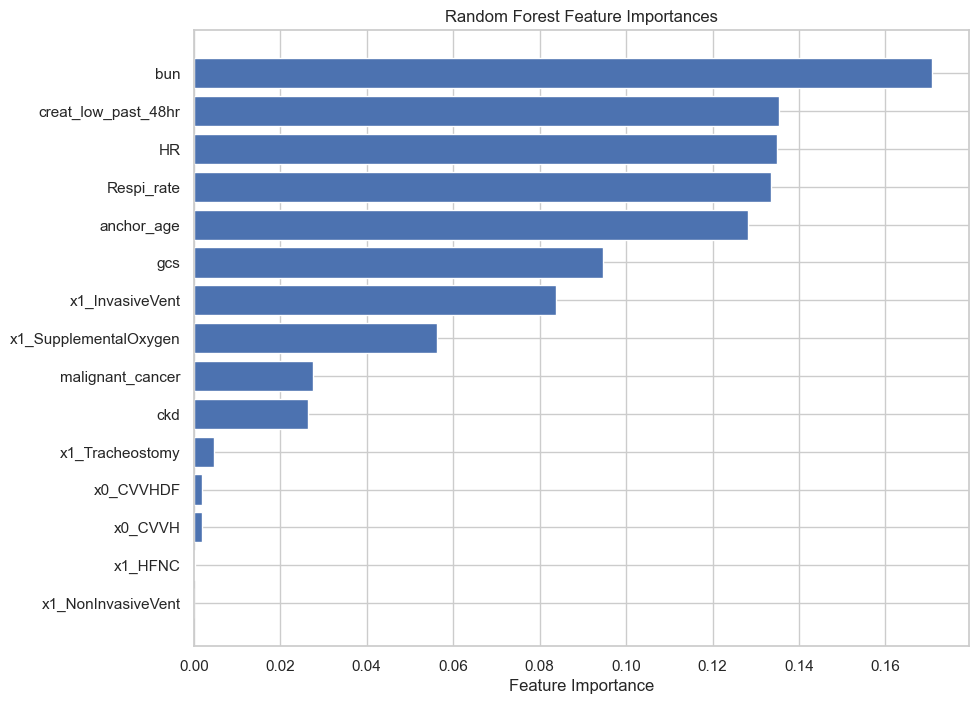

In [1114]:
preprocessor = clf_rf.named_steps['preprocessor']

cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
num_features = X.select_dtypes(include=['int64', 'float64']).columns  

feature_names = np.concatenate([num_features, cat_features])

sorted_indices = np.argsort(clf_rf.named_steps['classifier'].feature_importances_)[::-1]
sorted_importances = clf_rf.named_steps['classifier'].feature_importances_[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_feature_names)), sorted_importances, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.gca().invert_yaxis()  
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

In [1115]:
categorical_cols = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(exclude=['object']).columns),
        ('cat', categorical_transformer, categorical_cols)
    ])

clf_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['bun', 'gcs', 'HR', 'Respi_rate', 'malignant_cancer', 'anchor_age',
       'creat_low_past_48hr', 'ckd'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['crrt_mode', 'ventilation_status'], dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [1116]:
cat_features = clf_lr.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
num_features = X.select_dtypes(exclude=['object']).columns  
feature_names = np.concatenate([num_features, cat_features]) 

coefficients = clf_lr.named_steps['classifier'].coef_[0]
intercept = clf_lr.named_steps['classifier'].intercept_[0]


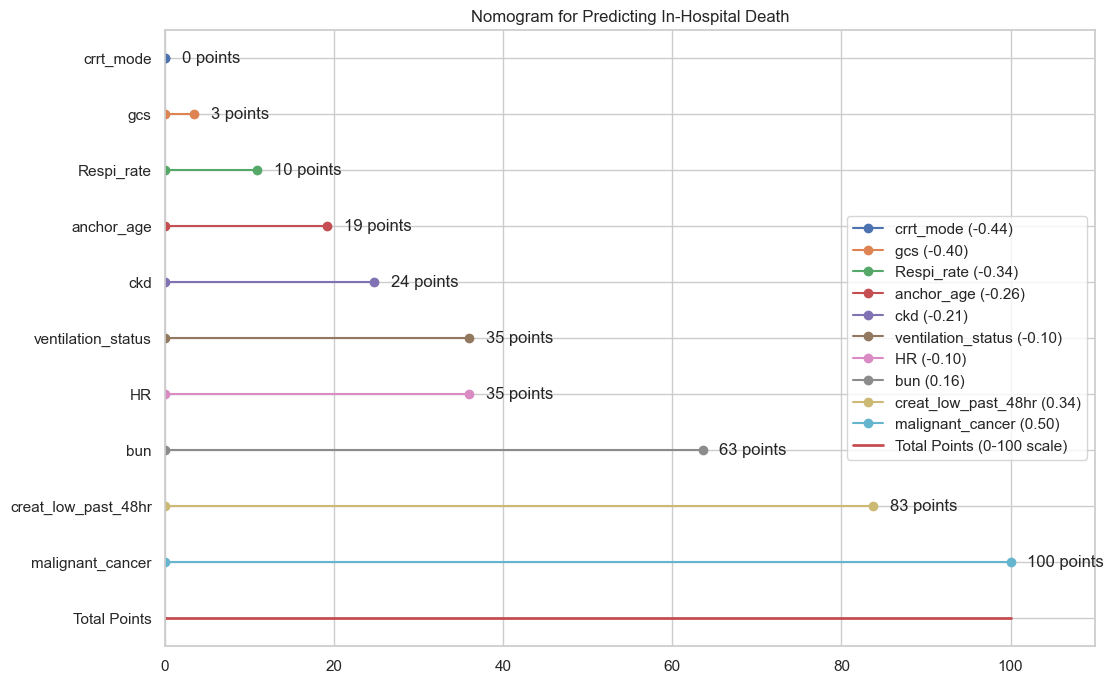

In [1117]:
def plot_nomogram(coef, features, intercept):
    min_coef = np.min(coef)
    max_coef = np.max(coef)
    points_scale = np.linspace(min_coef, max_coef, num=100)

    fig, ax = plt.subplots(figsize=(12, 8))
    
    feature_points = {feature: ((coef[i] - min_coef) / (max_coef - min_coef)) * 100 for i, feature in enumerate(features)}
    sorted_features = sorted(feature_points, key=feature_points.get)  

    for i, feature in enumerate(sorted_features):
        points = feature_points[feature]
        ax.plot([0, points], [i, i], 'o-', label=f"{feature} ({coef[np.where(features == feature)[0][0]]:.2f})")
        ax.text(points + 2, i, f"{int(points)} points", verticalalignment='center')

    ax.plot([0, 100], [i + 1, i + 1], 'r-', lw=2, label='Total Points (0-100 scale)')

    ax.set_yticks(range(len(sorted_features) + 1))
    ax.set_yticklabels(sorted_features + ['Total Points'])
    ax.set_xlim([0, 110])
    ax.set_title("Nomogram for Predicting In-Hospital Death")
    ax.invert_yaxis()  
    ax.legend(loc='right')

    plt.show()

coefficients = np.random.rand(10) - 0.5  
features = np.array(['bun', 'crrt_mode', 'gcs', 'HR', 'Respi_rate', 'malignant_cancer', 'anchor_age', 'creat_low_past_48hr', 'ventilation_status', 'ckd'])
intercept = -0.05

plot_nomogram(coefficients, features, intercept)


In [1118]:
df = pd.read_csv('Final.csv')
df = pd.get_dummies(df, drop_first=True)  

In [1119]:
for column in df.select_dtypes(include=['int', 'float']).columns:
    median_value = df[column].median()  
    df[column] = df[column].fillna(median_value)  

for column in df.select_dtypes(include=['object']).columns:
    mode_value = df[column].mode()[0] 
    df[column] = df[column].fillna(mode_value) 

In [1120]:
for column in df.select_dtypes(include=['int', 'float']).columns:
    lower_bound = df[column].quantile(0.01)
    upper_bound = df[column].quantile(0.99)
    df[column] = np.clip(df[column], lower_bound, upper_bound)


In [1121]:
variance_filter = VarianceThreshold(threshold=0.01)
df = pd.DataFrame(variance_filter.fit_transform(df), columns=df.columns[variance_filter.get_support()])

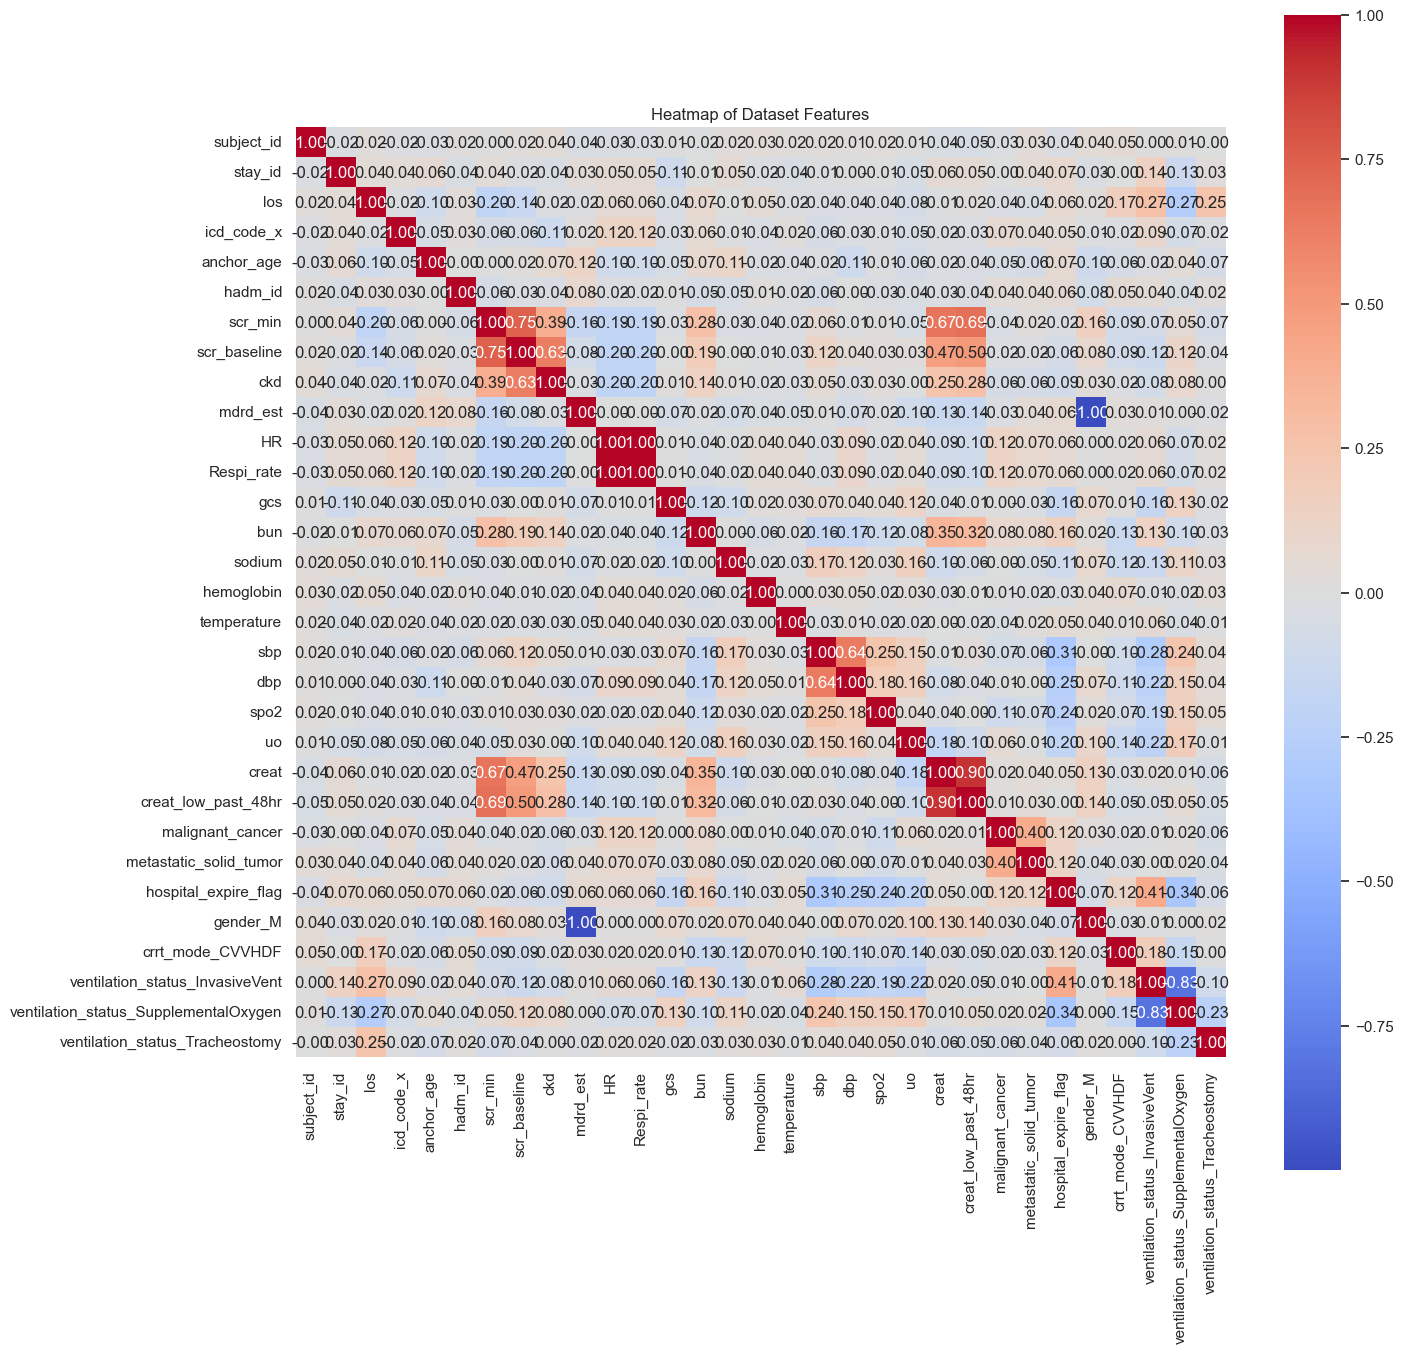

In [1122]:
corr = df.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap of Dataset Features')
plt.show()

In [1123]:
X = df.drop('hospital_expire_flag', axis=1)
y = df['hospital_expire_flag']

In [1124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

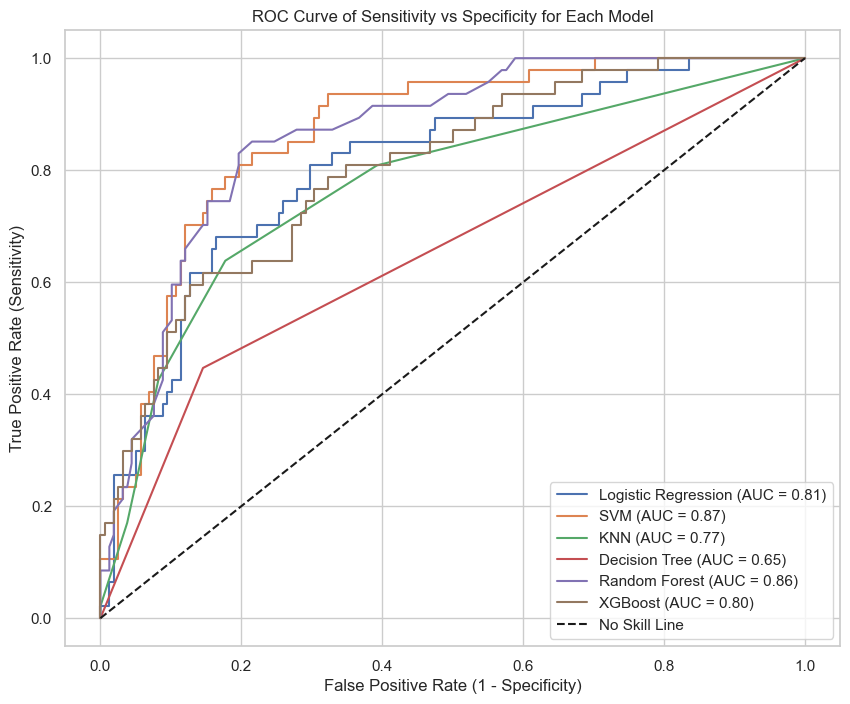

In [1125]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

fpr_dict = {}
tpr_dict = {}
auc_dict = {}

for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_test_scaled)[:, 1]
    else:  
        y_scores = clf.decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    fpr_dict[name] = fpr
    tpr_dict[name] = tpr
    auc_dict[name] = calculate_auc(fpr, tpr)

plt.figure(figsize=(10, 8))
for name in classifiers:
    plt.plot(fpr_dict[name], tpr_dict[name], label=f'{name} (AUC = {auc_dict[name]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill Line')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve of Sensitivity vs Specificity for Each Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [1126]:
base_models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(eval_metric='logloss'))
]

final_estimator = LogisticRegression()

stack_model = StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=5)

stack_model.fit(X_train_scaled, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(max_iter=1000)),
                               ('svm', SVC(probability=True)),
                               ('knn', KNeighborsClassifier()),
                               ('dt', DecisionTreeClassifier()),
                               ('rf', RandomForestClassifier()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              earl...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression())

In [1127]:
print(f"Accuracy on Test Set: {stack_model.score(X_test_scaled, y_test)}")

Accuracy on Test Set: 0.8048780487804879


In [1128]:
y_pred = stack_model.predict(X_test_scaled)
y_pred_proba = stack_model.predict_proba(X_test_scaled)[:, 1] 
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.86520333961756


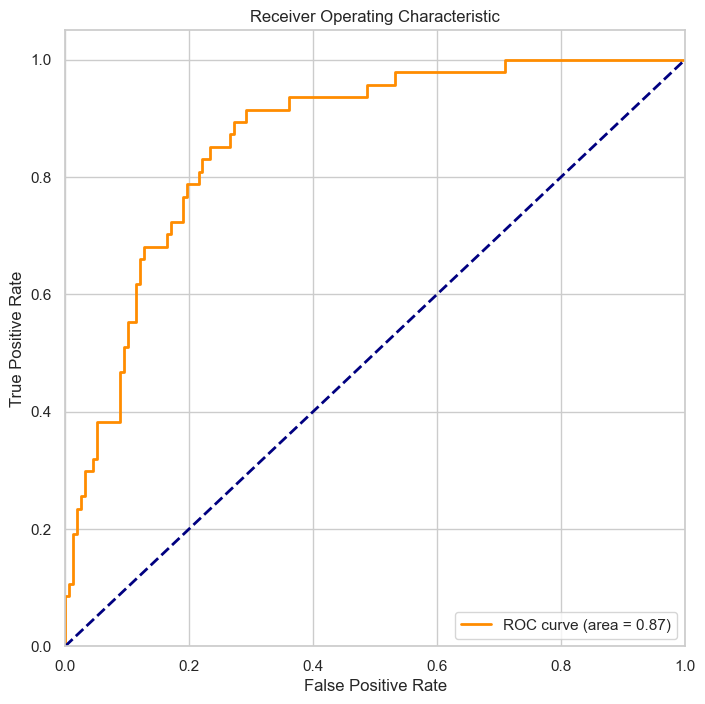

In [1129]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = calculate_auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [1130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1131]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc

cat_model = CatBoostClassifier(iterations=500, depth=3, learning_rate=0.05, loss_function='Logloss', verbose=0)
cat_model.fit(X_train_scaled, y_train)

cat_probs = cat_model.predict_proba(X_test_scaled)[:, 1]

cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
cat_auc = auc(cat_fpr, cat_tpr)


In [1132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

def build_model(input_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),
        Dense(128),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

y_train_cat = to_categorical(y_train)

nn_model = build_model(X_train_scaled.shape[1])
nn_model.fit(X_train_scaled, y_train_cat, epochs=50, batch_size=32, verbose=0)

nn_probs = nn_model.predict(X_test_scaled)[:, 1]

nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)
nn_auc = auc(nn_fpr, nn_tpr)


/Users/nissanthneelakandanabirami/Downloads/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nissanthneelakandanabirami/Downloads/.venv/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/var/folders/3t/_b6g8knj39g9p92hxh64xcfc0000gn/T/ipykernel_38565/739201886.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='No Skill Line', color='red')


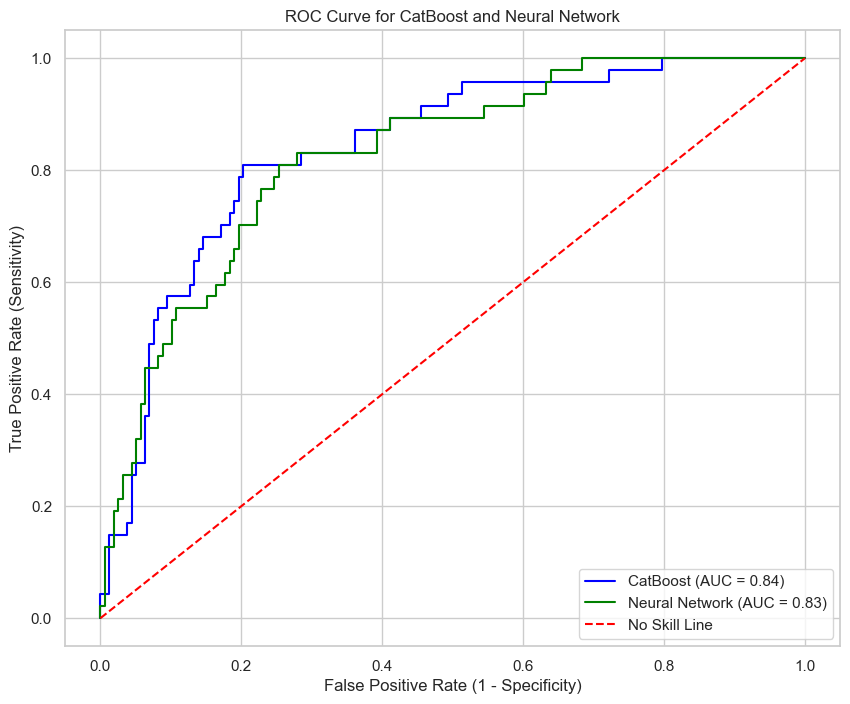

In [1133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(cat_fpr, cat_tpr, label=f'CatBoost (AUC = {cat_auc:.2f})', color='blue')
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill Line', color='red')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for CatBoost and Neural Network')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [1134]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
adaboost.fit(X_train_scaled, y_train)
adaboost_probs = adaboost.predict_proba(X_test_scaled)[:, 1]

ada_fpr, ada_tpr, _ = roc_curve(y_test, adaboost_probs)
ada_auc = auc(adaboost_fpr, adaboost_tpr)


/Users/nissanthneelakandanabirami/Downloads/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [1135]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
gbm.fit(X_train_scaled, y_train)
gbm_probs = gbm.predict_proba(X_test_scaled)[:, 1]

gbm_fpr, gbm_tpr, _ = roc_curve(y_test, gbm_probs)
gbm_auc = auc(gbm_fpr, gbm_tpr)


/var/folders/3t/_b6g8knj39g9p92hxh64xcfc0000gn/T/ipykernel_38565/877458098.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='No Skill Line', color='red')


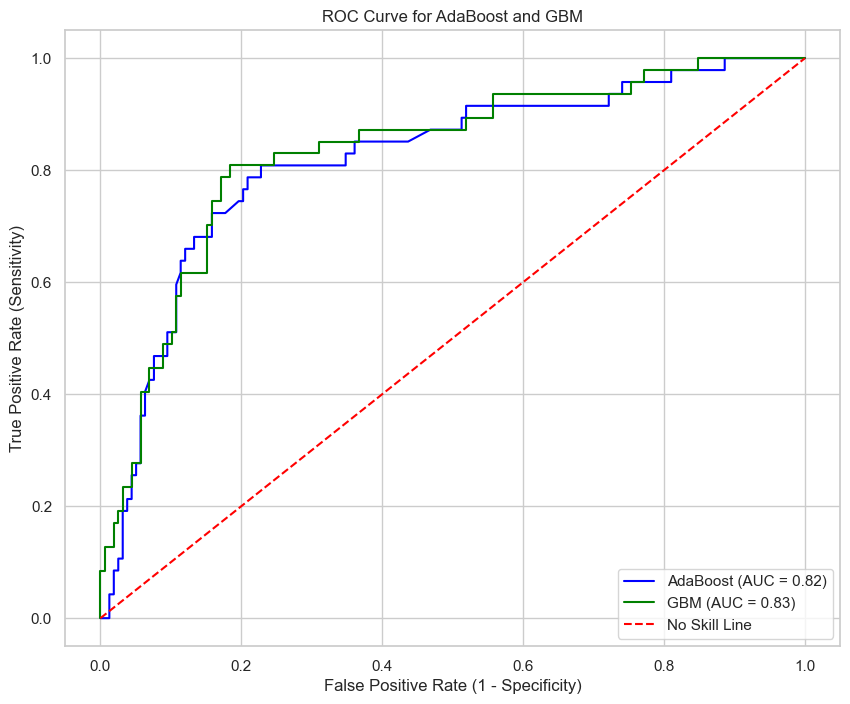

In [1136]:
plt.figure(figsize=(10, 8))
plt.plot(ada_fpr, ada_tpr, label=f'AdaBoost (AUC = {ada_auc:.2f})', color='blue')
plt.plot(gbm_fpr, gbm_tpr, label=f'GBM (AUC = {gbm_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill Line', color='red')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for AdaBoost and GBM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
